In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2023-05-10 21:47:36.645958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preparing The Data

In [2]:
import pathlib
import tensorflow as tf

# Download and extract the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

# Convert the data_dir path to a Path object
data_dir = pathlib.Path(data_dir)

In [3]:
# Print the path to the dataset directory
print("Dataset directory:", data_dir)

Dataset directory: /Users/eridon/.keras/datasets/flower_photos


/Users/eridon/.keras/datasets/flower_photos/roses/16209331331_343c899d38.jpg


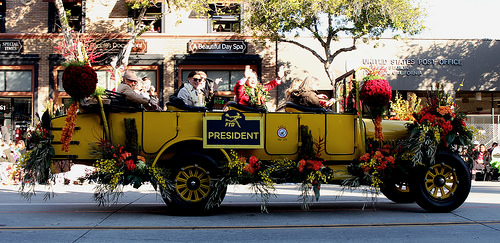

In [4]:
# Get a list of file paths for images in the 'roses' directory
roses = list(data_dir.glob('roses/*'))

# Print the path of the first image
print(roses[0])

# Open the first image using PIL
PIL.Image.open(str(roses[0]))

In [5]:
import numpy as np

# Set the desired height and width for the images
img_height, img_width = 180, 180

# Set the batch size for training
batch_size = 32

# Load and preprocess the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# Get the class names from the training dataset
class_names = train_ds.class_names

# Convert labels to integer data type
train_ds = train_ds.map(lambda x, y: (x, tf.keras.backend.cast(y, dtype=tf.int32)))

# Apply one-hot encoding to the labels
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, len(class_names))))

# Prefetch the dataset to optimize data loading
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-10 21:47:48.557179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load and preprocess the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

# Convert class names to numerical labels
label_map = {class_name: i for i, class_name in enumerate(val_ds.class_names)}

# Apply one-hot encoding to the labels
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, len(val_ds.class_names))))

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
import os

# Convert data_dir to a Path object for easier manipulation
data_dir = pathlib.Path(data_dir)

# Directories to exclude from the class names
exclude_dirs = ['.DS_Store', 'LICENSE.txt']

# Get the class names by filtering the directories in the data directory
class_names = [name for name in os.listdir(data_dir) if os.path.isdir(data_dir / name) and name not in exclude_dirs]

print(class_names)

['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']


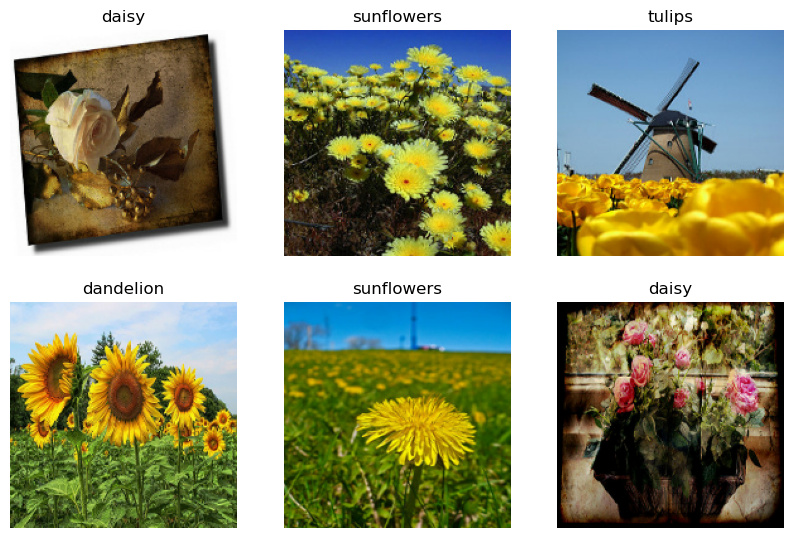

In [8]:
import matplotlib.pyplot as plt

# Create a figure to display the images
plt.figure(figsize=(10, 10))

# Iterate over the first batch of images and labels in the training dataset
for images, labels in train_ds.take(1):
    # Iterate over a subset of images in the batch
    for i in range(6):
        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Get the index of the predicted class for the current image
        label_index = tf.argmax(labels[i])
        
        # Get the class name corresponding to the predicted class index
        class_name = class_names[label_index]
        
        # Set the title of the subplot to the class name
        plt.title(class_name)
        
        # Disable the axis labels
        plt.axis("off")

# Training The Model


In [9]:
# Create a new sequential model
resnet_model = Sequential()

# Load the pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180, 180, 3),
    pooling='avg',
    classes=5,
    weights='imagenet'
)

# Set all layers of the pre-trained model as non-trainable
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model to the sequential model
resnet_model.add(pretrained_model)

# Add a Flatten layer to convert the output into a 1D tensor
resnet_model.add(Flatten())

# Add a Dense layer with 512 units and ReLU activation
resnet_model.add(Dense(512, activation='relu'))

# Add the final Dense layer with the number of classes as units and softmax activation
resnet_model.add(Dense(len(class_names), activation='softmax'))

In [10]:
# Print a summary of the model architecture
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrapp  (None, 2048)             0         
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 512)              1049088   
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 5)                2565      
 pper)                                                           
                                                                 
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
____________________________________

In [11]:
# Compile the model with specified optimiser, loss function, and metrics
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
# Number of training epochs
epochs = 5

# Fit the model to the training data and validate it on the validation data
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 202s 2s/step - loss: 0.6660 - accuracy: 0.7776 - val_loss: 0.3896 - val_accuracy: 0.8501
Epoch 2/5
92/92 [==============================] - 203s 2s/step - loss: 0.2586 - accuracy: 0.9091 - val_loss: 0.3521 - val_accuracy: 0.8651
Epoch 3/5
92/92 [==============================] - 204s 2s/step - loss: 0.1564 - accuracy: 0.9458 - val_loss: 0.4382 - val_accuracy: 0.8542
Epoch 4/5
92/92 [==============================] - 208s 2s/step - loss: 0.0864 - accuracy: 0.9741 - val_loss: 0.4273 - val_accuracy: 0.8624
Epoch 5/5
92/92 [==============================] - 372s 4s/step - loss: 0.0788 - accuracy: 0.9751 - val_loss: 0.4232 - val_accuracy: 0.8583


# Evaluating The Model

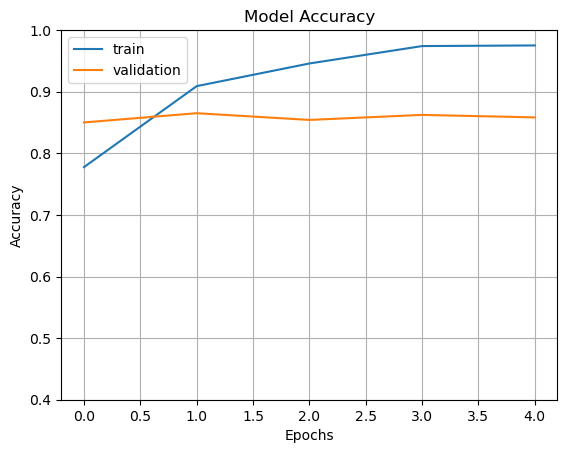

In [18]:
# Get the current figure
fig1 = plt.gcf()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Set the y-axis limits
plt.axis(ymin=0.4, ymax=1)

# Add a grid to the plot
plt.grid()

# Set the title and axis labels
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

# Add a legend to the plot
plt.legend(['train', 'validation'])

# Display the plot
plt.show()

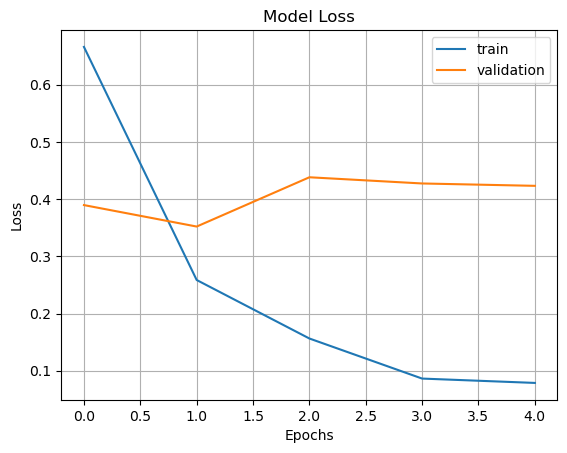

In [19]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Add a grid to the plot
plt.grid()

# Set the title and axis labels
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Add a legend to the plot
plt.legend(['train', 'validation'])

# Display the plot
plt.show()

# Making Predictions

In [23]:
import cv2

# Read the image using OpenCV
image = cv2.imread(str(roses[0]))

# Resize the image to the desired height and width
image_resized = cv2.resize(image, (img_height, img_width))

# Expand the dimensions of the image to match the expected input shape of the model
image = np.expand_dims(image_resized, axis=0)

# Print the shape of the image
print(image.shape)

(1, 180, 180, 3)


In [27]:
# Make predictions on the image using the trained model
pred = resnet_model.predict(image)

# Print the prediction results
print(pred)

1/1 [==============================] - 0s 109ms/step
[[1.6771598e-07 4.7460627e-09 9.9845266e-01 1.4609221e-09 1.5472412e-03]]


In [25]:
# Retrieve the predicted class name using the index from the class_names list
output_class=class_names[np.argmax(pred)]

# Print the predicted class
print("The predicted class is", output_class)

The predicted class is daisy
